**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

# Data Preparation

In [5]:
class_name = 'Occupancy'
df = pd.read_csv('occupancy_data/datatraining.txt', skipinitialspace=True, na_values='?', keep_default_na=True)
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [6]:
def daytime(h):
    if 6 <= h < 13:
        return 'morning'
    elif 13 <= h < 18:
        return 'afternoon'
    elif 18 <= h < 22:
        return 'evening'
    return 'night'

In [7]:
df['daytime'] = [daytime(d.hour) for d in pd.to_datetime(df['date'])]
df['weekend'] = [1 if d.weekday() >= 5 else 0 for d in pd.to_datetime(df['date'])]

In [8]:
columns2remove = ['date']
df.drop(columns2remove, inplace=True, axis=1)
df0 = df.copy()
dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
dfY = df[class_name]
df = pd.concat([dfX, dfY], axis=1)
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,weekend,daytime=afternoon,daytime=evening,daytime=morning,daytime=night,Occupancy
1,23.18,27.2720,426.0,721.25,0.004793,0,1,0,0,0,1
2,23.15,27.2675,429.5,714.00,0.004783,0,1,0,0,0,1
3,23.15,27.2450,426.0,713.50,0.004779,0,1,0,0,0,1
4,23.15,27.2000,426.0,708.25,0.004772,0,1,0,0,0,1
5,23.10,27.2000,426.0,704.50,0.004757,0,1,0,0,0,1


# Data Partitioning

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [10]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [11]:
X_train.shape

(5700, 10)

# Classification

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9914040114613181
F1-score [0.99456381 0.97947214]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1924
           1       0.99      0.97      0.98       519

    accuracy                           0.99      2443
   macro avg       0.99      0.98      0.99      2443
weighted avg       0.99      0.99      0.99      2443



# Variance Threshold

In [14]:
from sklearn.feature_selection import VarianceThreshold

In [15]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_train_sel = sel.fit_transform(X_train)

X_train_sel.shape

(5700, 7)

In [16]:
X_test_sel = sel.transform(X_test)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9905853458862055
F1-score [0.99404916 0.97747307]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1924
           1       0.99      0.96      0.98       519

    accuracy                           0.99      2443
   macro avg       0.99      0.98      0.99      2443
weighted avg       0.99      0.99      0.99      2443



# Univariate Feature Selection

In [17]:
from sklearn.feature_selection import SelectKBest

In [18]:
sel = SelectKBest(k=10)
X_train_sel = sel.fit_transform(X_train, y_train)

X_train_sel.shape

(5700, 10)

In [19]:
X_test_sel = sel.transform(X_test)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9914040114613181
F1-score [0.99456381 0.97947214]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1924
           1       0.99      0.97      0.98       519

    accuracy                           0.99      2443
   macro avg       0.99      0.98      0.99      2443
weighted avg       0.99      0.99      0.99      2443



# Recursive Feature Elimination

In [20]:
from sklearn.feature_selection import SelectFromModel

In [21]:
sel = SelectFromModel(DecisionTreeClassifier())
X_train_sel = sel.fit_transform(X_train, y_train)
X_train_sel.shape

(5700, 1)

In [22]:
X_test_sel = sel.transform(X_test)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9836266884977487
F1-score [0.98959417 0.96161228]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1924
           1       0.96      0.97      0.96       519

    accuracy                           0.98      2443
   macro avg       0.97      0.98      0.98      2443
weighted avg       0.98      0.98      0.98      2443



# Principal Component Analysis

In [23]:
from sklearn.decomposition import PCA

In [24]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [25]:
X_train_pca.shape

(5700, 2)

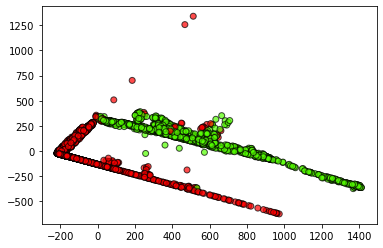

In [26]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [27]:
X_test_pca = pca.transform(X_test)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9836266884977487
F1-score [0.98961039 0.96138996]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1924
           1       0.96      0.96      0.96       519

    accuracy                           0.98      2443
   macro avg       0.98      0.97      0.98      2443
weighted avg       0.98      0.98      0.98      2443



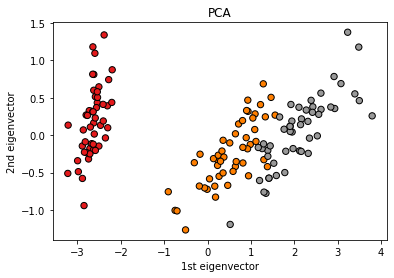

In [28]:
from sklearn import datasets

iris = datasets.load_iris()
X_pca = PCA(n_components=2).fit_transform(iris.data)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=iris.target, cmap=plt.cm.Set1, edgecolor='k', s=40)
plt.title("PCA")
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")
plt.show()

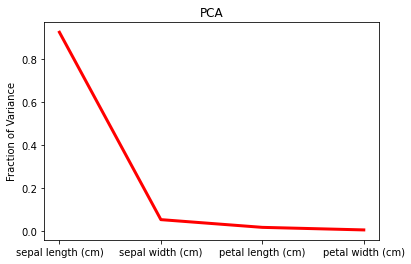

In [29]:
plt.plot(PCA(n_components=4).fit(iris.data).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.xticks(range(4), iris.feature_names)
plt.show()